In [1]:
!adb exec-out run-as si.fri.matevzfa.approxhpvmdemo cat "databases/classification-log" > classification-log
!adb exec-out run-as si.fri.matevzfa.approxhpvmdemo cat "databases/classification-log-shm" > classification-log-shm
!adb exec-out run-as si.fri.matevzfa.approxhpvmdemo cat "databases/classification-log-wal" > classification-log-wal

In [2]:
import sqlite3
import pandas as pd
import ipywidgets as widgets

con = sqlite3.connect("classification-log")

df_full = pd.read_sql_query("SELECT * FROM trace_classification", con)

df_full["timestamp"] = pd.to_datetime(df_full["timestamp"], infer_datetime_format=True)
df_full["run_start"] = pd.to_datetime(df_full["run_start"], infer_datetime_format=True)
df_full["trace_run_start"] = pd.to_datetime(df_full["trace_run_start"], infer_datetime_format=True)


starts = df_full["trace_run_start"].sort_values(ascending=False).unique()
mapped = [s.strftime("%a %-d %b %Y %H:%M:%S") for s in starts]

w = widgets.Select(
    options=list(zip(mapped, starts)),
    description="Select run",
)
w

Select(description='Select run', options=(('Thu 2 Sep 2021 09:52:01', Timestamp('2021-09-02 09:52:01.049000+02…

In [3]:
import matplotlib.pyplot as plt
import numpy as np

labels = [
    "Walking",
    "W. Upstairs",
    "W. Downstairs",
    "Sitting",
    "Standing",
    "Lying",
]

energy_coeffs = [
    1,
    0.858578929,
    0.83936881,
    0.839488128,
    0.827675695,
    0.916209283,
    0.854074693,
    0.847124448,
    0.779829376,
    0.815236845,
]

df = df_full[df_full["trace_run_start"] == w.value].copy()
df


,uid,timestamp,run_start,trace_run_start,used_config,argmax,argmax_baseline,confidence_concat,confidence_baseline_concat,used_engine
2833,2834,2021-09-01 14:43:35.001000+02:00,2021-09-01 14:43:28.493000+02:00,2021-09-02 09:52:01.049000+02:00,0,0,0,"0.99977165,4.6991216E-5,7.2303716E-5,2.5439054...","0.99977165,4.6991216E-5,7.2303716E-5,2.5439054...",StateAdaptation_x1
2834,2835,2021-09-01 14:43:35.001000+02:00,2021-09-01 14:43:28.493000+02:00,2021-09-02 09:52:01.049000+02:00,0,0,0,"0.99977165,4.6991216E-5,7.2303716E-5,2.5439054...","0.99977165,4.6991216E-5,7.2303716E-5,2.5439054...",StateAdaptation_x2
2835,2836,2021-09-01 14:43:35.001000+02:00,2021-09-01 14:43:28.493000+02:00,2021-09-02 09:52:01.049000+02:00,0,0,0,"0.99977165,4.6991216E-5,7.2303716E-5,2.5439054...","0.99977165,4.6991216E-5,7.2303716E-5,2.5439054...",KalmanAdaptation_x1
2836,2837,2021-09-01 14:43:35.001000+02:00,2021-09-01 14:43:28.493000+02:00,2021-09-02 09:52:01.049000+02:00,0,0,0,"0.99977165,4.6991216E-5,7.2303716E-5,2.5439054...","0.99977165,4.6991216E-5,7.2303716E-5,2.5439054...",KalmanAdaptation_x2
2837,2838,2021-09-01 14:43:35.001000+02:00,2021-09-01 14:43:28.493000+02:00,2021-09-02 09:52:01.049000+02:00,0,0,0,"0.99977165,4.6991216E-5,7.2303716E-5,2.5439054...","0.99977165,4.6991216E-5,7.2303716E-5,2.5439054...",HARConfidenceAdaptation_x1
...,...,...,...,...,...,...,...,...,...,...
4586,4587,2021-09-01 14:56:41.790000+02:00,2021-09-01 14:43:28.493000+02:00,2021-09-02 09:52:01.049000+02:00,9,3,3,"0.0025397115,0.011310759,0.24655189,0.6907772,...","3.920712E-7,2.4275691E-6,5.4755333E-6,0.999986...",StateAdaptation_x2
4587,4588,2021-09-01 14:56:41.790000+02:00,2021-09-01 14:43:28.493000+02:00,2021-09-02 09:52:01.049000+02:00,9,3,3,"0.0025397115,0.011310759,0.24655189,0.6907772,...","3.920712E-7,2.4275691E-6,5.4755333E-6,0.999986...",KalmanAdaptation_x1
4588,4589,2021-09-01 14:56:41.790000+02:00,2021-09-01 14:43:28.493000+02:00,2021-09-02 09:52:01.049000+02:00,9,3,3,"0.0025397115,0.011310759,0.24655189,0.6907772,...","3.920712E-7,2.4275691E-6,5.4755333E-6,0.999986...",KalmanAdaptation_x2
4589,4590,2021-09-01 14:56:41.790000+02:00,2021-09-01 14:43:28.493000+02:00,2021-09-02 09:52:01.049000+02:00,6,3,3,"4.8312443E-4,0.003604866,0.034944776,0.942646,...","3.920712E-7,2.4275691E-6,5.4755333E-6,0.999986...",HARConfidenceAdaptation_x1


=== HARConfidenceAdaptation_x1 ===
        accuracy=0.8327645051194539
 relative_energy=0.852410050679181
 consumed_energy=249.756144849


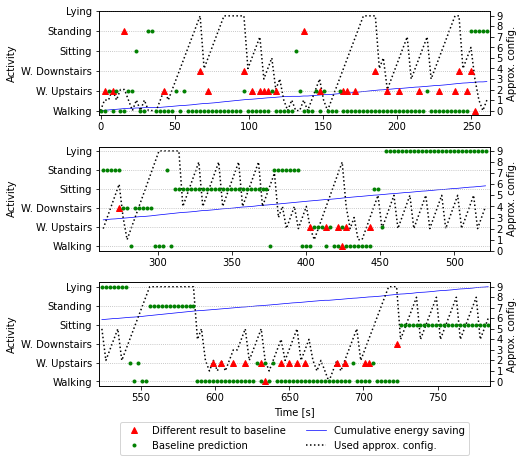

missing: 0
=== HARConfidenceAdaptation_x2 ===
        accuracy=0.8054607508532423
 relative_energy=0.8485200149317406
 consumed_energy=248.616364375


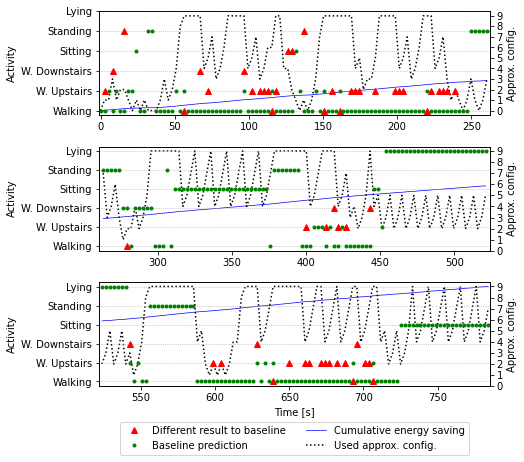

missing: 0
=== KalmanAdaptation_x1 ===
        accuracy=0.8498293515358362
 relative_energy=0.8685294178737203
 consumed_energy=254.47911943700004


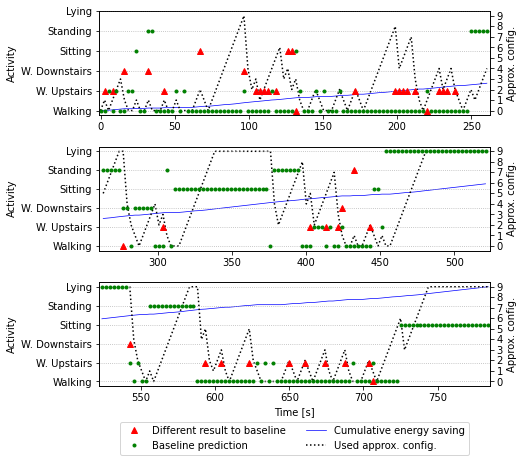

missing: 0
=== KalmanAdaptation_x2 ===
        accuracy=0.825938566552901
 relative_energy=0.8511868426075087
 consumed_energy=249.39774488400002


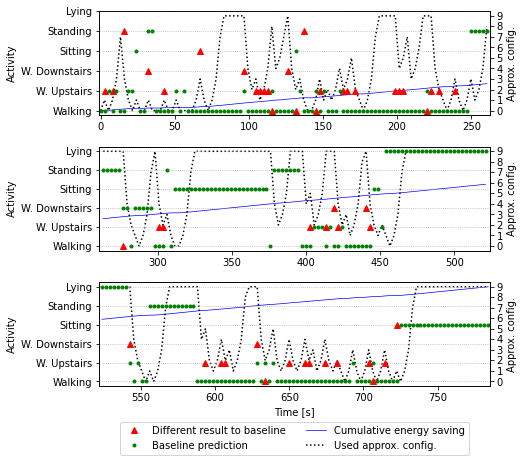

missing: 0
=== StateAdaptation_x1 ===
        accuracy=0.9044368600682594
 relative_energy=0.8892187880273038
 consumed_energy=260.541104892


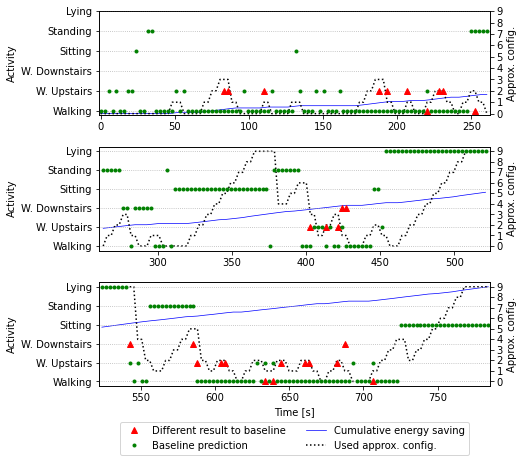

missing: 0
=== StateAdaptation_x2 ===
        accuracy=0.8873720136518771
 relative_energy=0.8799798259863483
 consumed_energy=257.834089014


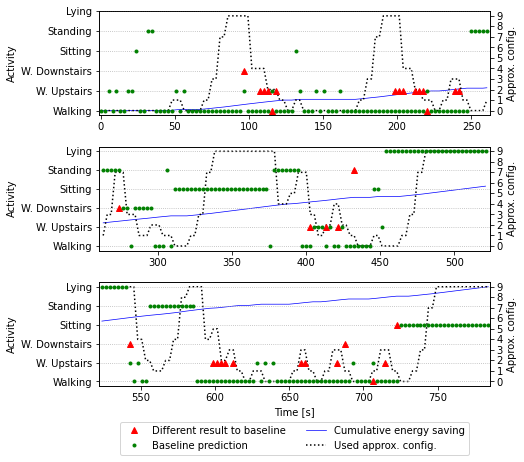

missing: 0


In [4]:
for engine, grp in df.groupby(["used_engine"]):
    print(f"=== {engine} ===")
    grp = grp.reset_index()

    grp.sort_values(["timestamp"], inplace=True)

    grp["timestamp"] = (grp["timestamp"] - grp["timestamp"].min()) / pd.to_timedelta(1, unit='s')

    maxtime = grp.timestamp.max()
    step = maxtime/len(grp)
    grp["timestamp"] = grp.index.map(lambda i: i*step)

    consumed_energy = grp.used_config.map(lambda x: energy_coeffs[x]).sum()
    relative_energy = consumed_energy / len(grp)
    accuracy = (grp.argmax == grp.argmax_baseline).sum() / len(grp)

    print(f"        accuracy={accuracy}")
    print(f" relative_energy={relative_energy}")
    print(f" consumed_energy={consumed_energy}")

    grp["energy"] = grp.used_config.map(lambda x: 1-energy_coeffs[x]).cumsum()
    grp["energy"] /= grp["energy"].max()

    grp["energy"] *= len(energy_coeffs)-1

    perrow_cca = 100
    nrows = int(np.ceil(len(grp) / perrow_cca))

    perrow_seconds = grp.timestamp.max() / nrows

    fig, axs = plt.subplots(nrows=nrows, figsize=(7, nrows*2.3))
    axs = np.array(axs).reshape(-1)
    plt.subplots_adjust(hspace=0.3)

    plotted = 0

    for i, ax1 in enumerate(axs):

        ts_min = i*perrow_seconds
        ts_max = (i+1)*perrow_seconds

        df_sub = grp.loc[(ts_min <= grp.timestamp) & (grp.timestamp <= ts_max), :]

        plotted += len(df_sub)

        ax2 = ax1.twinx()

        ln_saving = ax2.plot(df_sub.timestamp, df_sub.energy, 'b-', lw=.7, label="Cumulative energy saving")
        ln_conf = ax2.plot(df_sub.timestamp, df_sub.used_config, 'k:', label="Used approx. config.")
        ax2.set_yticks(list(range(10)))
        ax2.set_yticklabels(list(range(10)))

        wrong = df_sub[df_sub.argmax != df_sub.argmax_baseline]

        # for ts in wrong.timestamp:
        #     ax1.axvline(ts, c='gray', ls=':', lw=1)

        ax1.grid(ls=':', axis='y')
        ln_r = ax1.plot(wrong.timestamp, wrong.argmax, 'r^', label="Different result to baseline")
        ln_g = ax1.plot(df_sub.timestamp, df_sub.argmax_baseline, 'g.', label="Baseline prediction")
        ax1.set_yticks(list(range(len(labels))))
        ax1.set_yticklabels(labels)

        ax1.set_xlim(ts_min-1, ts_max+1)

        ax1.set_ylabel("Activity")
        ax2.set_ylabel("Approx. config.")

        ax1.set_zorder(ax2.zorder+1)
        ax1.patch.set_visible(False)

    lns = ln_r + ln_g + ln_saving + ln_conf
    axs[-1].legend(lns, [l.get_label() for l in lns],
                   loc="center", bbox_to_anchor=[0.5, -0.5], ncol=2)

    axs[-1].set_xlabel("Time [s]")
    time = grp["run_start"].unique()[0]
    fig.savefig(f"adaptation-{engine}-{str(time).replace(' ', '-')}.pdf", bbox_inches='tight')
    plt.show()

    print(f"missing: {plotted - len(grp)}")
